In [37]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from prophet import Prophet

In [38]:
tickers = pd.read_json('../data/tickers.json')
df = pd.read_csv('../data/data_NU.csv')

In [39]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-12-09,11.25,12.24,10.01,10.33,90160800,0.0,0.0
1,2021-12-10,11.45,11.85,9.80,11.85,50077300,0.0,0.0
2,2021-12-13,11.10,11.29,10.31,10.81,19658400,0.0,0.0
3,2021-12-14,10.55,10.58,9.27,9.92,22728100,0.0,0.0
4,2021-12-15,9.63,10.29,9.42,10.01,12663900,0.0,0.0


In [40]:
df['Variacao'] = (df['Open'] - df['Close']) / df['Open']
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Variacao
0,2021-12-09,11.25,12.24,10.01,10.33,90160800,0.0,0.0,0.081778
1,2021-12-10,11.45,11.85,9.80,11.85,50077300,0.0,0.0,-0.034935
2,2021-12-13,11.10,11.29,10.31,10.81,19658400,0.0,0.0,0.026126
3,2021-12-14,10.55,10.58,9.27,9.92,22728100,0.0,0.0,0.059716
4,2021-12-15,9.63,10.29,9.42,10.01,12663900,0.0,0.0,-0.039460


In [41]:
variation = [df['Variacao'] == 0, df['Variacao'] > 0, df['Variacao'] < 0]

colours = ['blue', 'green', 'red']

colours_np = np.select(variation, colours, default='black')

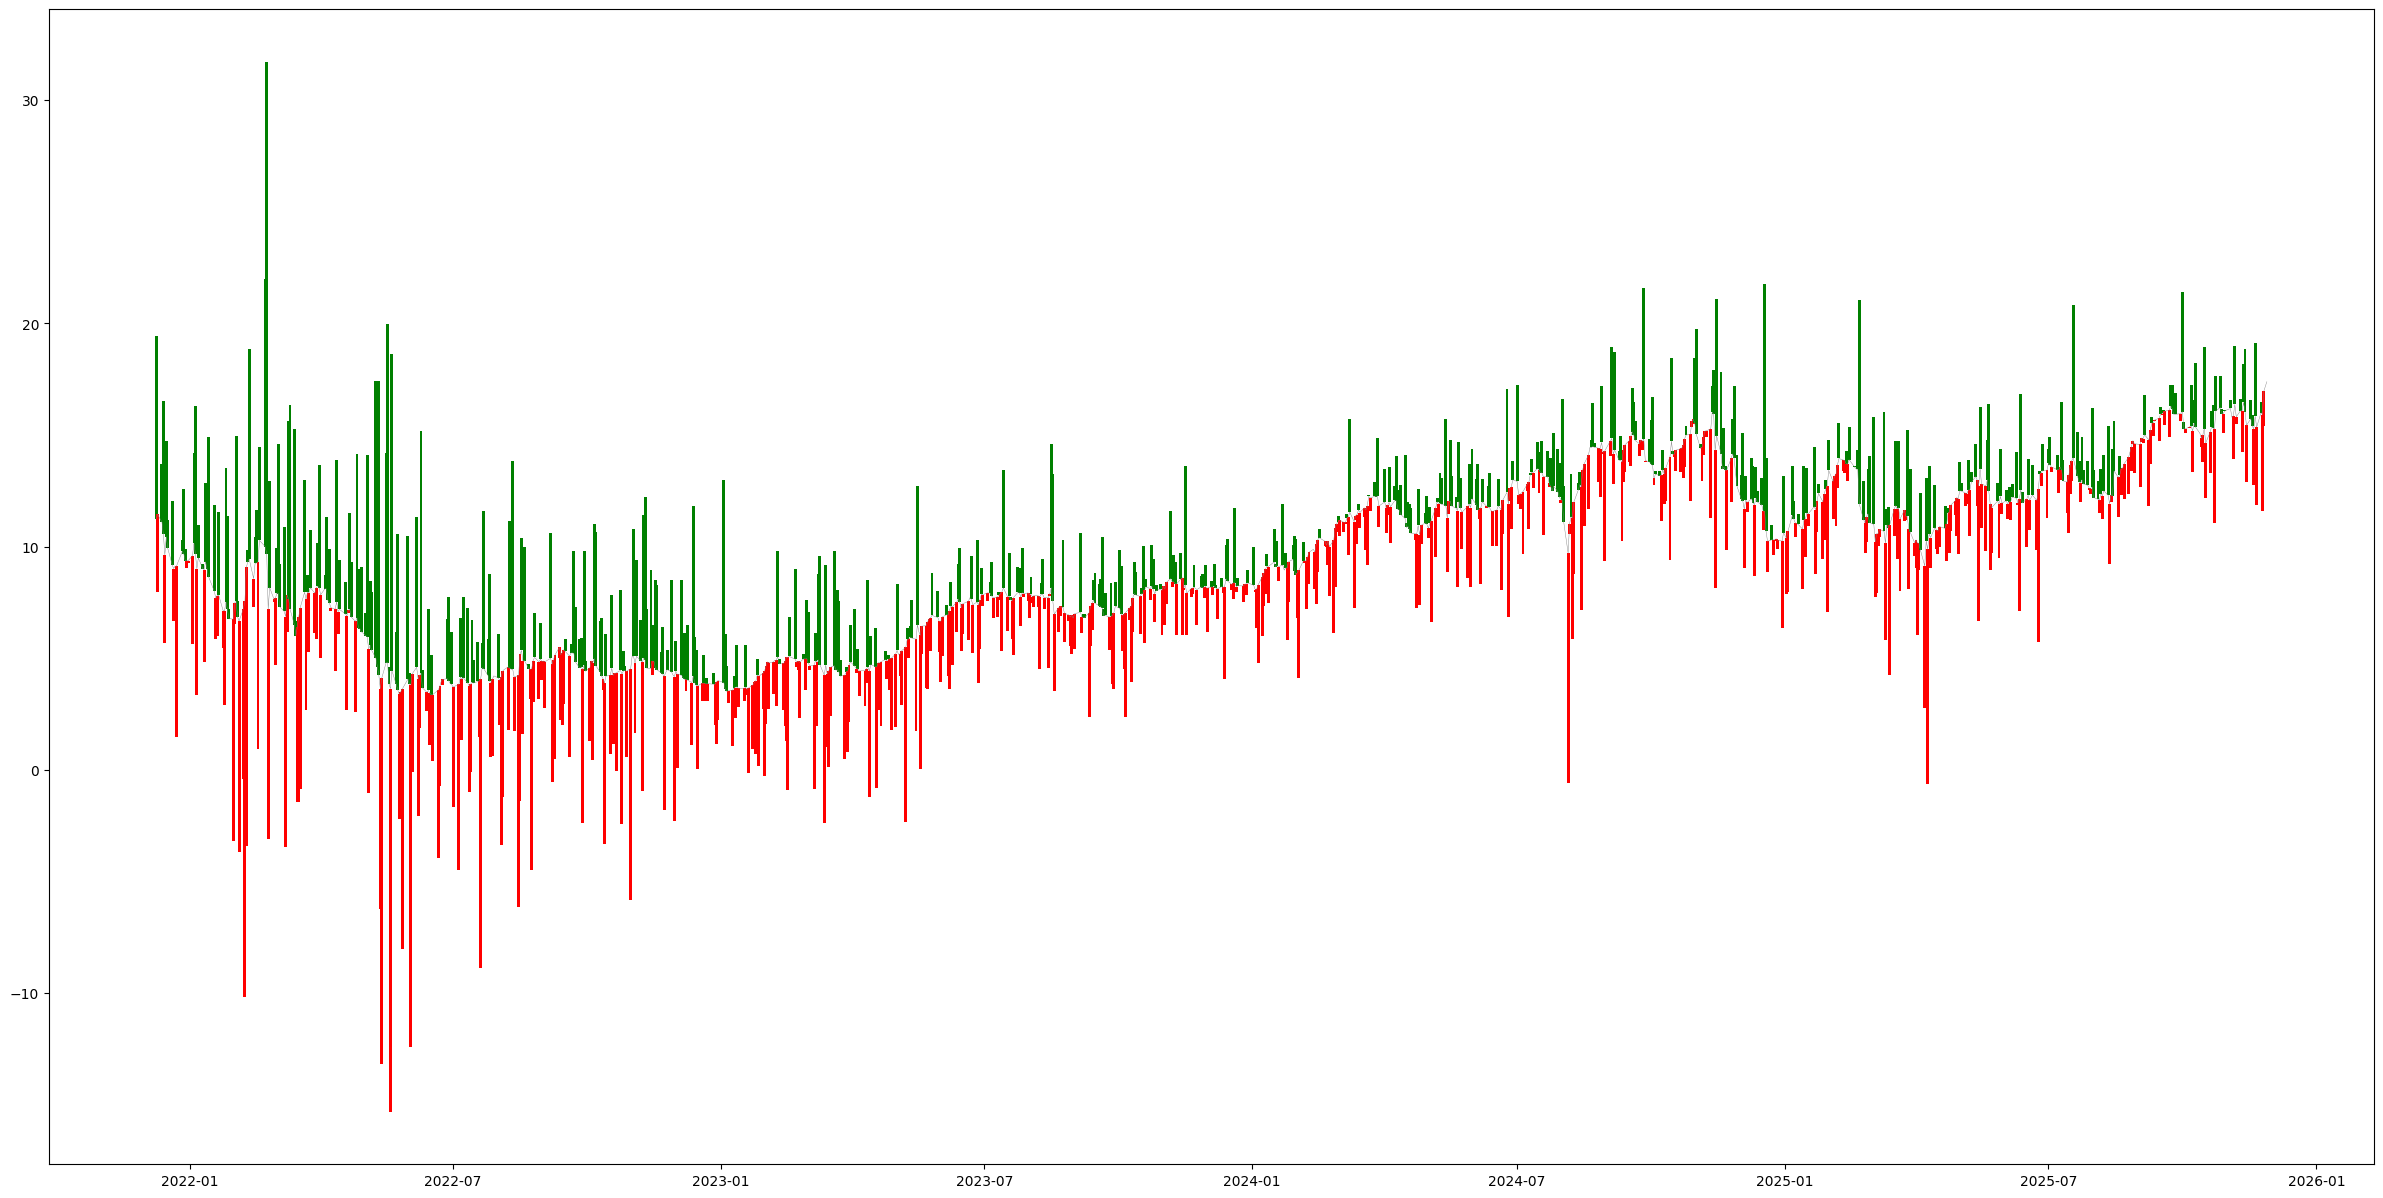

In [42]:
plt.figure(figsize=(30, 15))
plt.bar(df['Date'], df['Variacao'] * 100, bottom=df['Open'], color=colours_np, width=2)
plt.plot(df['Date'], df['Open'], linewidth=0.3, color='grey')
plt.show()

In [43]:
plt.clf()
higher = np.where(np.abs(df['Variacao']) > 0.05)  # Buscar um numero bom para isso
df_higher = df.loc[higher]
df_higher['Date'].head()
to_save = df_higher['Date'].to_list()
with open('../data/NU_date.json', 'w') as file:
    json.dump(to_save, file, indent=4, ensure_ascii=False, default=str)

<Figure size 640x480 with 0 Axes>

In [44]:
plt.clf()
plt.figure(figsize=(30, 15))
plt.bar(df_higher['Date'], df_higher['Variacao'] * 100, bottom=df_higher['Open'], width=2)
plt.plot(df_higher['Date'], df_higher['Open'], linewidth=0.3, color='black')
# plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

In [45]:
data = {'ds': pd.to_datetime(df['Date']), 'y': df['Open']}
df1 = pd.DataFrame(data)

m = Prophet()
m.fit(df1)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

16:32:28 - cmdstanpy - INFO - Chain [1] start processing
16:32:29 - cmdstanpy - INFO - Chain [1] done processing


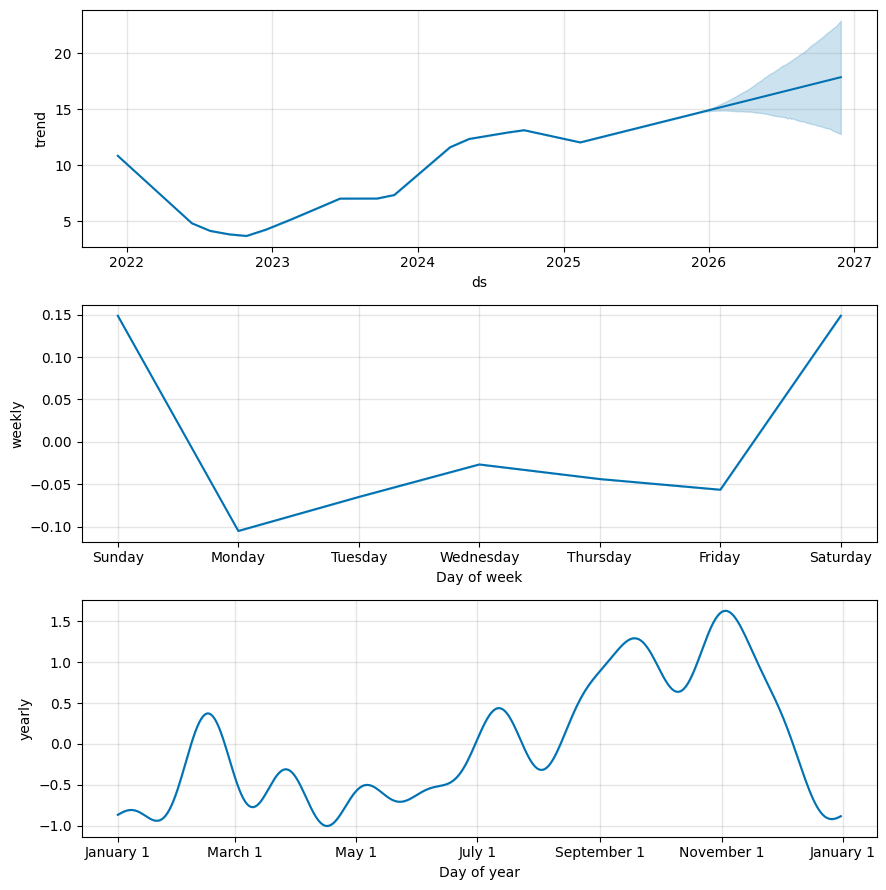

In [46]:
fig2 = m.plot_components(forecast)
plt.show()

<>:7: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:7: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
/tmp/ipykernel_138898/1345091316.py:7: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  plt.title('Componente de Aleatoriedade ($\epsilon_t$)')


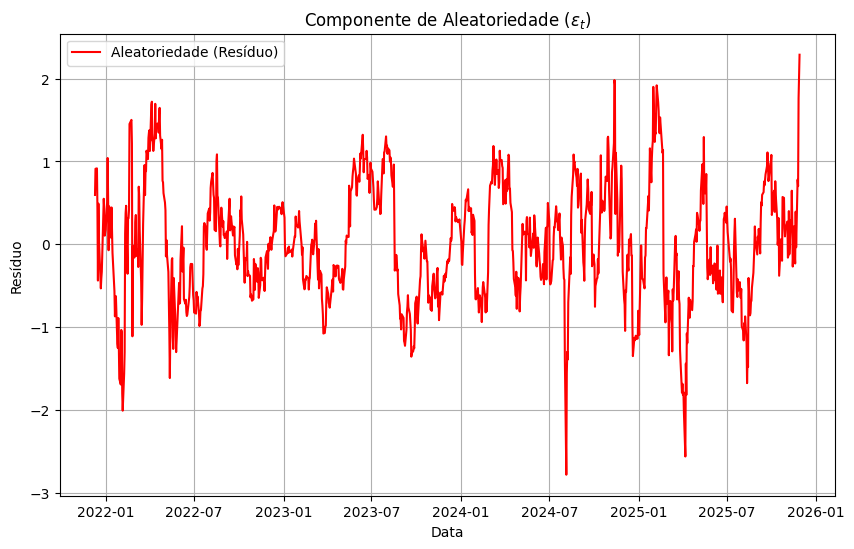

In [47]:
df_comp = pd.merge(df1, forecast[['ds', 'yhat', 'trend', 'additive_terms', 'multiplicative_terms']], on='ds')

df_comp['residuo'] = df_comp['y'] - df_comp['yhat']

plt.figure(figsize=(10, 6))
plt.plot(df_comp['ds'], df_comp['residuo'], label='Aleatoriedade (Resíduo)', color='red')
plt.title('Componente de Aleatoriedade ($\epsilon_t$)')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.grid(True)
plt.legend()
plt.show()

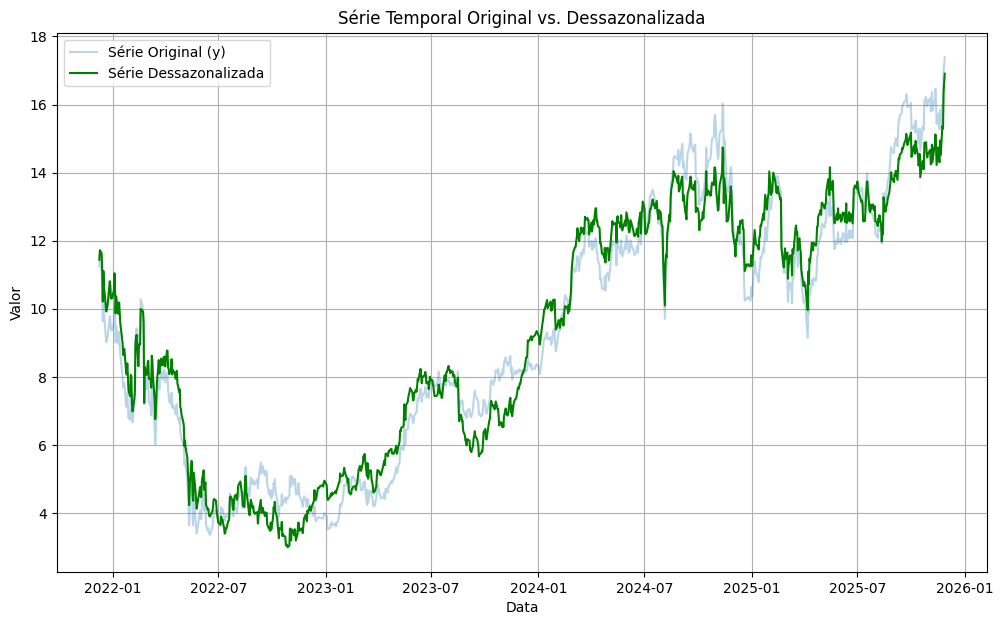

In [48]:
sazonalidade_total = df_comp['additive_terms']

df_comp['dessazonalizada'] = df_comp['y'] - sazonalidade_total

plt.figure(figsize=(12, 7))
plt.plot(df_comp['ds'], df_comp['y'], label='Série Original (y)', alpha=0.3)
plt.plot(df_comp['ds'], df_comp['dessazonalizada'], label='Série Dessazonalizada', color='green')
plt.title('Série Temporal Original vs. Dessazonalizada')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.show()